# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from google.colab import files
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Functions

In [2]:
# function to convert datatype to float32 and replace NaN and infinity values with zero and some large number respectively.
def convert_to_float32(df):
  for i in range(len(df.columns)):
    if df[df.columns[i]].dtype == 'float64':
      df[df.columns[i]] = np.nan_to_num(df[df.columns[i]].astype(np.float32))
  return df

In [3]:
# Creating blocks for each set of smoothening range and technical indicators
blocks = []
technical_indicators = np.array(['sma','wma','ema','tema','dema','rsi','std','roc','mom','var','BBupper','BBmiddle','BBlower'])
smoothening_range = np.array(['3','7','30','90'])
for p in smoothening_range:
  for t in technical_indicators:
    string = p + t
    blocks.append(string)

In [4]:
# Function to select technical features
def tech_feature_selection(x,y):
  """ 
      this function selects most important feature from each block
  """
  list_of_selected_features=[]
  for string in blocks:
    print('Block:',string)
    new_df=x.filter(like=string,axis=1)
    new_df = pd.DataFrame(new_df)
    new_df.columns=x.filter(like=string,axis=1).columns
    estimator = RandomForestRegressor(random_state=42)
    selector = RFECV(estimator, step=0.6,verbose=True,scoring='neg_mean_absolute_error',n_jobs=-1)
    selector = selector.fit(new_df, y)
    mask = selector.get_support()
    new_features = new_df.columns[mask]
    print('Feature Rankings',selector.ranking_)
    if len(new_features.values)>1:
      estimator.fit(new_df, y)
      for j in range(len(estimator.feature_importances_)):
        if estimator.feature_importances_.max() == estimator.feature_importances_[j]:
          new_features = new_df.columns[j]
          print('Selected Feature:', new_features)
          list_of_selected_features.append(new_features)
    else:
      features = new_features.values
      for i in features:
        print(i)
        list_of_selected_features.append(i)
    print('Number of Selected Features:', len(list_of_selected_features))
    print('*'*50)
  return list_of_selected_features

In [5]:
# Function that measures Variance Inflation Factor
def VIF(data):
  vif_data = pd.DataFrame()
  vif_data["feature_vif"] = data.columns
  # calculating vif for each feature in train dataset
  vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
  return vif_data.sort_values(['VIF'],ascending = False)

In [6]:
def RanF_imp(x,y):
  regr_24=RandomForestRegressor(random_state=42)
  regr_24.fit(x,y)
  fea_imp_24 = pd.DataFrame({'Features':x.columns,'Feature_importances':list(regr_24.feature_importances_)}).sort_values(by = ['Feature_importances'],ascending=False)
  return fea_imp_24
def RanF_imp_plot(df):
  plot = df.sort_values(['Feature_importances'], ascending=[True]).tail(15).plot.barh(x='Features', y='Feature_importances',figsize=(15,8))
  return plot

# Loading data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
btc_data_24 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC  Price Prediction/BTC_feature_engineered_data_24.csv')

In [12]:
btc_data_24 = convert_to_float32(btc_data_24)

In [13]:
btc_data_24.shape

(2707, 1586)

### Dropping Redundant Features

In [14]:
Redundant_features = ['coins_in_supply']
for i in Redundant_features:
  btc_data_24 = btc_data_24[btc_data_24.columns.drop(list(btc_data_24.filter(regex=i)))]

In [15]:
btc_data_24.shape

(2707, 1520)

### Splitting the data into X, Y 

In [16]:
x_btc_data_24 = btc_data_24.drop(['next_day_BTC_price'], axis=1)
y_btc_data_24 = btc_data_24['next_day_BTC_price']

# Feature Selection

In [18]:
list_of_selected_features_24 = tech_feature_selection(x_btc_data_24,y_btc_data_24)

Block: 3sma
Fitting estimator with 23 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 2 3 3 3 3 3 3 3 2 3 3 2 3 2 2 2 2 1 2]
Close_3sma
Number of Selected Features: 1
**************************************************
Block: 3wma
Fitting estimator with 23 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 3 2 3 2 3 3 3 3 3 2 3 3 2 3 2 2 2 2 1 2]
Close_3wma
Number of Selected Features: 2
**************************************************
Block: 3ema
Fitting estimator with 23 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 2 3 3 3 3 3 3 2 3 3 3 2 3 2 2 2 2 1 2]
Close_3ema
Number of Selected Features: 3
**************************************************
Block: 3tema
Fitting estimator with 23 features.
Fitting estimator with 10 features.
Feature Rankings [3 3 3 2 3 3 2 3 3 3 3 2 3 3 3 2 3 2 2 2 2 1 2]
Close_3tema
Number of Selected Features: 4
**************************************************
Block: 3dema
Feature Rankings 

In [19]:
btc_data_24.columns[1:24]

Index(['transactions', 'size', 'sentbyaddress', 'difficulty', 'hashrate',
       'mining_profitability', 'sentinusd', 'transactionfees',
       'median_transaction_fee', 'confirmationtime', 'transactionvalue',
       'tweets', 'google_trends', 'mediantransactionvalue', 'activeaddresses',
       'top100cap', 'fee_to_reward', 'avg_price', 'Open', 'High', 'Low',
       'Close', 'miners_revenue'],
      dtype='object')

In [20]:
btc_data_24_raw = btc_data_24.iloc[:,1:24]

In [21]:
btc_data_24_tech = btc_data_24[list_of_selected_features_24]

In [22]:
VIF_24_tech = VIF(btc_data_24_tech)
VIF_24_tech.iloc[10:]

,feature_vif,VIF
39,transactionvalue_90sma,213.446533
28,High_30ema,199.643368
31,difficulty_30rsi,184.380239
41,transactionvalue_90ema,151.223937
50,transactionvalue_90BBmiddle,75.281335
18,difficulty_7rsi,70.916162
42,transactionvalue_90tema,56.812566
43,High_90dema,54.990819
32,tweets_30std,53.441809
12,Open_3BBlower,49.459970


In [23]:
tech_24 = btc_data_24[VIF_24_tech['feature_vif'].to_list()]

In [24]:
tech_24.drop(VIF_24_tech[VIF_24_tech['VIF']>10]['feature_vif'].to_list(),axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
tech_24.shape

(2707, 18)

In [26]:
VIF_24_raw = VIF(btc_data_24_raw)
VIF_24_raw

,feature_vif,VIF
4,hashrate,97.133890
3,difficulty,52.911522
17,avg_price,22.966046
19,High,22.949892
18,Open,22.910899
21,Close,22.480136
20,Low,22.402827
14,activeaddresses,10.342299
2,sentbyaddress,7.925108
10,transactionvalue,4.070218


In [27]:
raw_24 = btc_data_24_raw.copy()
raw_24.drop(VIF_24_raw[VIF_24_raw['VIF']>10]['feature_vif'].to_list(),axis=1,inplace=True)

In [28]:
raw_24.shape

(2707, 15)

In [29]:
data_24 = raw_24.join(tech_24)

In [ ]:
data_24.shape

(2684, 35)

In [30]:
fea_imp_24 = RanF_imp(data_24,y_btc_data_24)
fea_imp_24.head(25)

,Features,Feature_importances
17,Close_7sma,0.219086
22,Close_3tema,0.195101
19,High_30wma,0.166915
26,Close_3ema,0.160099
18,Close_3BBupper,0.151326
15,High_30BBmiddle,0.105345
14,miners_revenue,0.000351
9,tweets,0.000102
12,top100cap,0.000091
30,top100cap_30roc,0.000091


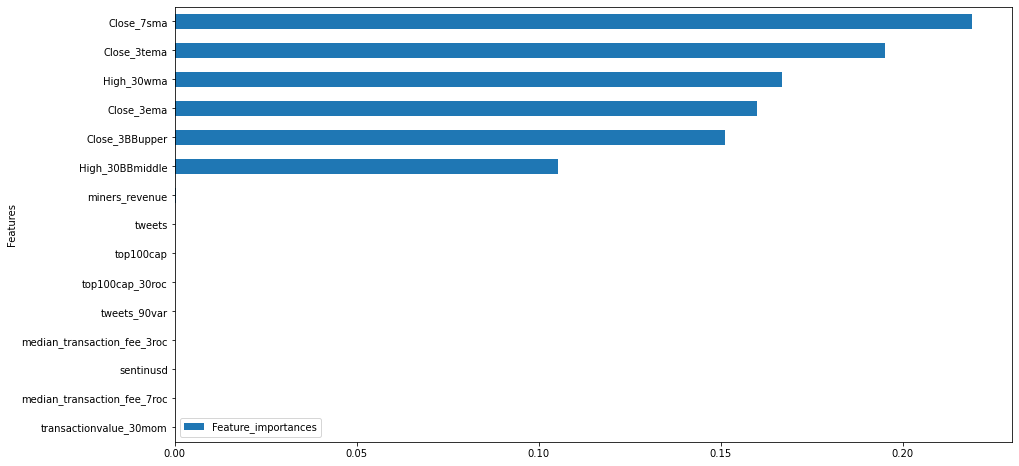

In [31]:
RanF_imp_plot(fea_imp_24)

In [32]:
selected_features_24 = fea_imp_24.iloc[:12,:-1]['Features'].to_list()

In [33]:
selected_features_24.insert(0, 'Date')
selected_features_24.insert(len(selected_features_24)+1, 'next_day_BTC_price')

In [34]:
selected_features_24

['Date',
 'Close_7sma',
 'Close_3tema',
 'High_30wma',
 'Close_3ema',
 'Close_3BBupper',
 'High_30BBmiddle',
 'miners_revenue',
 'tweets',
 'top100cap',
 'top100cap_30roc',
 'tweets_90var',
 'median_transaction_fee_3roc',
 'next_day_BTC_price']

In [35]:
data_selected_final_24 = btc_data_24[selected_features_24]

In [36]:
data_selected_final_24.to_csv('/content/drive/MyDrive/Colab Notebooks/BTC  Price Prediction/data_selected_final_24_4.csv', sep=',',index= False)